# Deriving Stats for Paper
S. Filhol

1. import data (model ensemble)
2. import masks for Retezat, Tarcu, Godeanu, Fagaras, Iezer, Parang
3. extract per massif: see Excel file

In [3]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rio

from tqdm import tqdm
import rasterio
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
threshold_oi = -2

## Parang Massif

In [6]:
ds = xr.open_dataset('./outputs/parang_ensemble.nc')
df = xr.open_dataset('./outputs/parang_all_maxent.nc')
# open aspect, and and open zoning (scree, etc)
with rasterio.open('./pm_inputs/parang_aspect.tif') as ras:
    aspect = ras.read(1)
aspect[aspect == -9999] = 0
# add aspect to ds
df['aspect'] = (('y', 'x'), np.flip(aspect, 0))

In [6]:
ds.model

<xarray.DataArray 'model' (model: 7)>
array(['Logistic Regression', 'Random Forest', 'Neural Net', 'Maxent',
       'Gradient Boost', 'AdaBoost', 'SVM'], dtype=object)
Coordinates:
  * model    (model) object 'Logistic Regression' 'Random Forest' ... 'SVM'

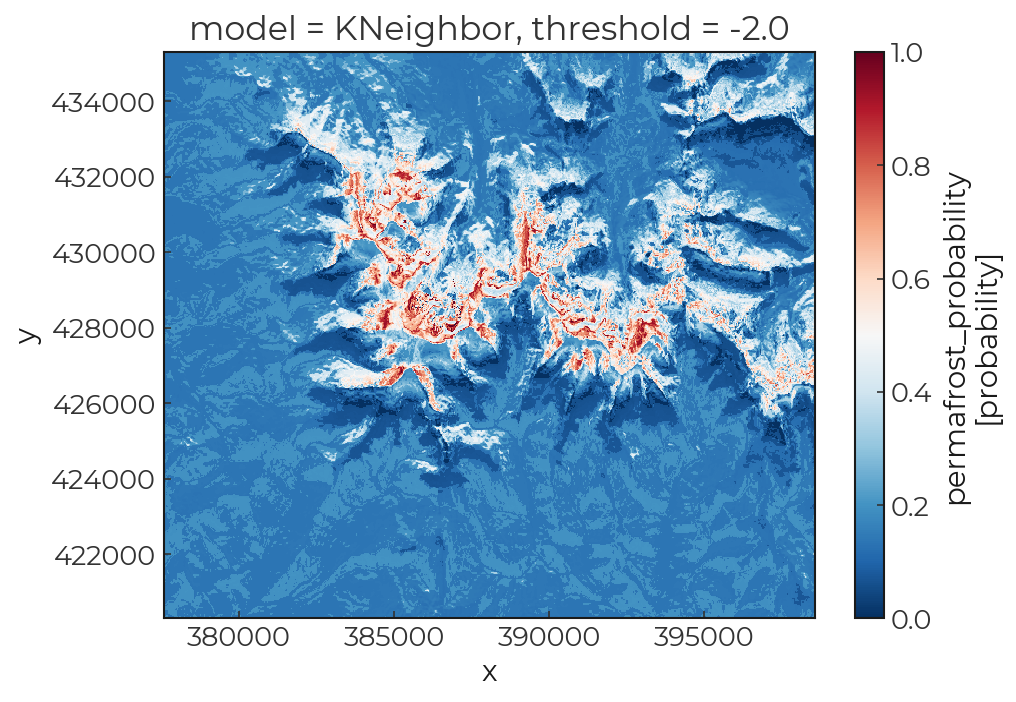

In [7]:
df.permafrost_probability.sel(threshold=threshold_oi, model='KNeighbor').plot(vmin=0,vmax=1, cmap=plt.cm.RdBu_r)
#df.permafrost_probability.sel(threshold=-2, model='keras').plot(vmin=0,vmax=1, cmap=plt.cm.RdBu_r)

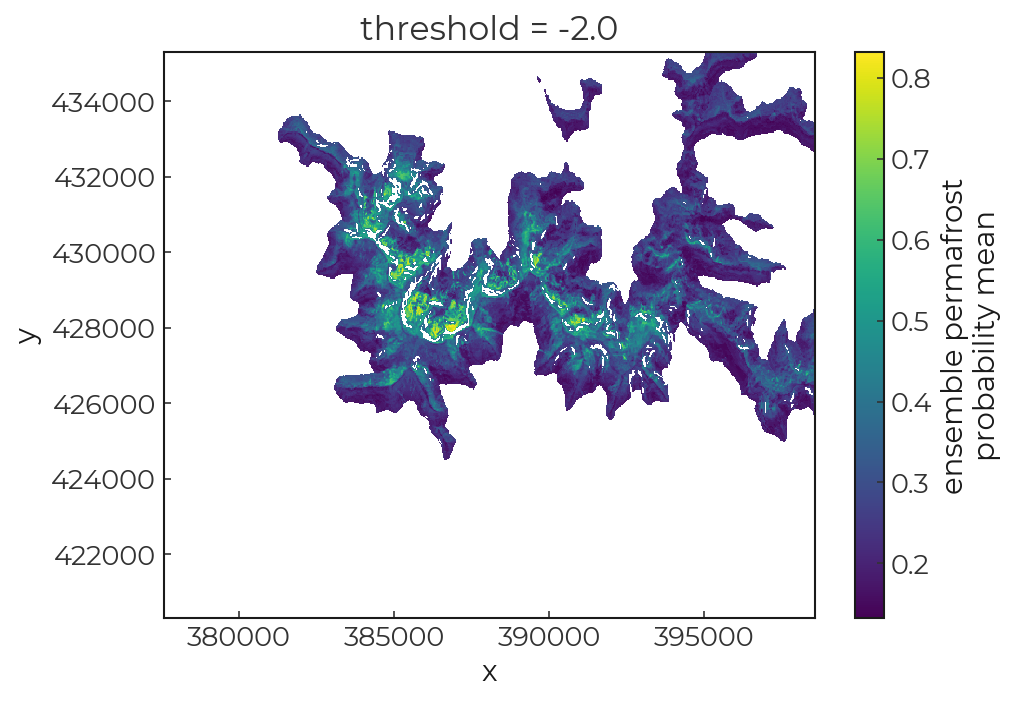

In [6]:
ds.pp_mean.sel(threshold=threshold_oi).plot()

In [47]:
ds

<xarray.Dataset>
Dimensions:    (model: 6, y: 500, x: 700, threshold: 3)
Coordinates:
  * model      (model) object 'Logistic Regression' ... 'KNeighbor'
  * threshold  (threshold) float64 -3.0 -2.5 -2.0
  * x          (x) float64 3.776e+05 3.776e+05 3.776e+05 ... 3.985e+05 3.985e+05
  * y          (y) float64 4.203e+05 4.203e+05 4.204e+05 ... 4.353e+05 4.353e+05
Data variables:
    pp_mean    (y, x, threshold) float64 ...
    pp_median  (y, x, threshold) float64 ...
    pp_q25     (y, x, threshold) float64 ...
    pp_q75     (y, x, threshold) float64 ...
    pp_std     (y, x, threshold) float64 ...
Attributes:
    description:    Permafrost extent modeling in the Romanian Carpathians
    author:         Simon Filhol
    creation_date:  2022/09/13 17:36:46
    massif:         parang

In [9]:
def nr(num):
    return np.round(num, 2)

thresh = [-2,-2.5, -3]
for t in thresh:
    print(f'Parang Massif (threshold={t} degC)')
    print('\t Elevation >1850 total area = ', nr(((df.elevation>=1850).sum()*0.03*0.03).values), ' km2')
    print('\t Scree total area (NDVI<0.52) = ', nr(((df.ndvi<0.52).sum()*0.03*0.03).values), ' km2')
    print('\t PP>50% total area (median) = ', nr(((ds.sel(threshold=t).pp_median>0.5).sum()*0.03*0.03).values), ' km2')
    print('\t PP>50% total area (0.75 percentile) = ', nr(((ds.sel(threshold=t).pp_q75>0.5).sum()*0.03*0.03).values), ' km2')
    print('\t PP>50% total area (0.25 percentile) = ', nr(((ds.sel(threshold=t).pp_q25>0.5).sum()*0.03*0.03).values), ' km2')

    

Parang Massif (threshold=-2 degC)
	 Elevation >1850 total area =  77.81  km2
	 Scree total area (NDVI<0.52) =  12.37  km2
	 PP>50% total area (median) =  3.73  km2
	 PP>50% total area (0.75 percentile) =  7.91  km2
	 PP>50% total area (0.25 percentile) =  2.06  km2
Parang Massif (threshold=-2.5 degC)
	 Elevation >1850 total area =  77.81  km2
	 Scree total area (NDVI<0.52) =  12.37  km2
	 PP>50% total area (median) =  2.9  km2
	 PP>50% total area (0.75 percentile) =  7.02  km2
	 PP>50% total area (0.25 percentile) =  1.4  km2
Parang Massif (threshold=-3 degC)
	 Elevation >1850 total area =  77.81  km2
	 Scree total area (NDVI<0.52) =  12.37  km2
	 PP>50% total area (median) =  1.71  km2
	 PP>50% total area (0.75 percentile) =  4.05  km2
	 PP>50% total area (0.25 percentile) =  0.75  km2


In [10]:

thresh = [-2,-2.5,-3]
for t in thresh:
    ens = pd.DataFrame()
    mini = pd.DataFrame()
    mini['pp_median'] = ds.pp_median.sel(threshold=t).values.flatten()

    # Median Absolute Deviation: https://en.wikipedia.org/wiki/Median_absolute_deviation
    #mini['pp_mad'] = np.fabs((dsm.permafrost_probability.sel(threshold=thres)-dsm.permafrost_probability.sel(threshold=thres).median(dim='model'))).median(dim='model').values.flatten()
    mini['slope'] = df.slope.values.flatten()
    mini['elevation'] = df.elevation.values.flatten()
    mini['solar'] = df.solar.values.flatten()
    mini['aspect'] = df.aspect.values.flatten()
    mini['ndvi'] = df.ndvi.values.flatten()
    mini['scree'] = df.ndvi.values.flatten() < 0.52
    mini['rockwalls'] = df.slope.values.flatten() > 45
    mini['permafrost'] = ds.pp_median.sel(threshold=t).values.flatten() > 0.5

    # remove areas outside of model prediciton range: slope > 45, and elev < 1850m
    mini = mini.dropna(axis=0)
    ens = ens.append(mini, ignore_index=True)

    elev_bin = np.append(np.arange(1850, 2350, 50), 2600)
    ens['elev_band'] = pd.cut(ens.elevation, elev_bin)


    aspect_bin = [0,  45 ,135, 225, 315,  360]
    aspect_name = ['N',  'W', 'S',  'E',  'N']
    ens['aspect_band'] = pd.cut(ens.aspect, aspect_bin)
    vec = ens.aspect_band.unique()
    ens['aspect_dir'] = ens.aspect_band.apply(lambda x: dict(zip(vec.categories, aspect_name)).get(x))

    dd = pd.DataFrame()
    dd['elevation_area_km2'] = (ens.groupby(['aspect_dir','elev_band']).count()*0.03*0.03).round(5).elevation
    dd['scree_area_km2'] = (ens.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).scree
    dd['permafrost_area_km2'] = (ens.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).permafrost
    dd['rockwalls_area_km2'] = (ens.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).rockwalls
    dd['median_scree_slope_permafrost_deg'] = ens.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(True, level=0).xs(True, level=0).slope
    dd['median_scree_slope_NO_permafrost_deg'] = ens.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(False, level=0).xs(True, level=0).slope
    dd['median_solar_permafrost'] = ens.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(True, level=0).solar
    dd['median_solar_NO_permafrost'] = ens.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(False, level=0).solar

    dd.to_csv(f'table_razvan_parang_{t}.csv')


## Retezat/Tarcul/Godeanu Massifs

In [12]:
threshold_oi = -2

In [11]:
ds = xr.open_dataset('./outputs/retezat_ensemble.nc')
df = xr.open_dataset('./outputs/retezat_all_maxent.nc')
# open aspect, and and open zoning (scree, etc)
with rasterio.open('./pm_inputs/retezat_aspect.tif') as ras:
    aspect = ras.read(1)
aspect[aspect == -9999] = 0
# add aspect to ds
df['aspect'] = (('y', 'x'), np.flip(aspect, 0))

In [13]:
(ds.pp_median.sel(threshold=-2)>0.5).sum().values*0.03*0.03

10.716299999999999

In [13]:
df

<xarray.Dataset>
Dimensions:                 (y: 1100, x: 1700, model: 6, threshold: 3)
Coordinates:
  * model                   (model) object 'KNeighbor' ... 'SVM'
  * threshold               (threshold) float64 -3.0 -2.5 -2.0
  * x                       (x) float64 3.052e+05 3.052e+05 ... 3.562e+05
  * y                       (y) float64 4.138e+05 4.139e+05 ... 4.468e+05
Data variables:
    curv                    (y, x) float64 ...
    elevation               (y, x) float32 ...
    mask                    (y, x) float32 ...
    ndvi                    (y, x) float32 ...
    permafrost_probability  (y, x, threshold, model) float64 ...
    slope                   (y, x) float32 ...
    snow_prob_median        (y, x) float64 ...
    solar                   (y, x) float32 ...
    aspect                  (y, x) float32 161.0 153.4 162.3 ... 183.6 180.0
Attributes:
    description:    Permafrost extent modeling in the Romanian Carpathians
    author:         Simon Filhol
    creation_date:  2022/09/13 17:19:45
    massif:         retezat

In [14]:
with rasterio.open('./pm_inputs/rgt_123_mask_bis.tif') as ras:
    massif = ras.read(1)
# add massif to ds
df['massif'] = (('y', 'x'), np.flip(massif, 0))

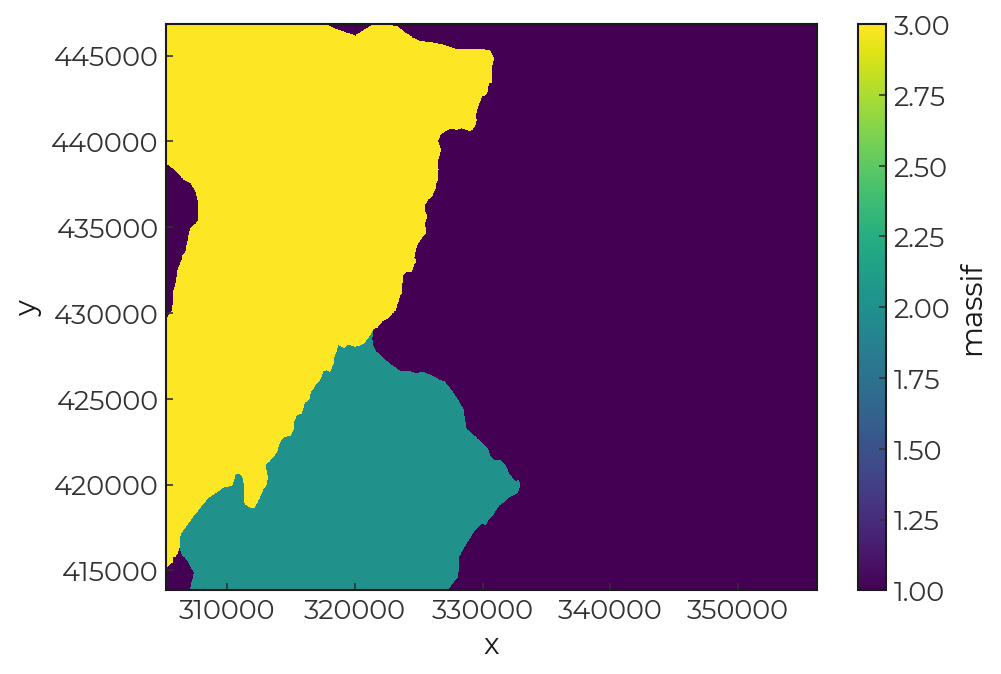

In [15]:
df.massif.plot()

In [16]:
ens = pd.DataFrame()
mini = pd.DataFrame()
mini['pp_median'] = ds.pp_median.sel(threshold=threshold_oi).values.flatten()
for mod in df.model.values:
    mini[mod] = df.permafrost_probability.sel(model=mod, threshold=threshold_oi).values.flatten()

# Median Absolute Deviation: https://en.wikipedia.org/wiki/Median_absolute_deviation
#mini['pp_mad'] = np.fabs((dsm.permafrost_probability.sel(threshold=thres)-dsm.permafrost_probability.sel(threshold=thres).median(dim='model'))).median(dim='model').values.flatten()
mini['slope'] = df.slope.values.flatten()
mini['elevation'] = df.elevation.values.flatten()
mini['solar'] = df.solar.values.flatten()
mini['aspect'] = df.aspect.values.flatten()
mini['ndvi'] = df.ndvi.values.flatten()
mini['scree'] = df.ndvi.values.flatten() < 0.52
mini['rockwalls'] = df.slope.values.flatten() > 45
mini['permafrost'] = ds.pp_median.sel(threshold=threshold_oi).values.flatten() > 0.5
mini['massif'] = df.massif.values.flatten()
mini['masc'] = df.mask.values.flatten()

# remove areas outside of model prediciton range: slope > 45, and elev < 1850m. NaNs are from the pp_median layer
mini = mini.dropna(axis=0)
#mini = mini.loc[mini.masc==1]
ens = ens.append(mini, ignore_index=True)

In [17]:
ens

pp_median  AdaBoost  Gradient Boost  KNeighbor  Logistic Regression  \
0        0.041018  0.410602        0.017241   0.058897             0.427691   
1        0.044929  0.410602        0.013801   0.059660             0.431355   
2        0.066109  0.410602        0.013801   0.116236             0.432034   
3        0.059673  0.407593        0.012290   0.114430             0.433236   
4        0.077395  0.407593        0.012290   0.119648             0.436513   
...           ...       ...             ...        ...                  ...   
225241   0.115022  0.413853        0.024467   0.302169             0.449689   
225242   0.106849  0.413425        0.021253   0.303873             0.450017   
225243   0.110929  0.413425        0.019456   0.307703             0.448932   
225244   0.124948  0.413425        0.021253   0.301117             0.447936   
225245   0.105855  0.413160        0.021253   0.341896             0.449994   

          Maxent  Neural Net  Random Forest       SVM      slope  elevation  \
0       0.000018    0.000564       0.023139  0.127920  21.260378     1854.0   
1       0.000015    0.000647       0.030198  0.124067  22.619865     1865.0   
2       0.000018    0.000673       0.030024  0.102195  18.962318     1874.0   
3       0.000024    0.000773       0.030024  0.089323  16.723558     1881.0   
4       0.000074    0.001385       0.060024  0.094766  17.576967     1889.0   
...          ...         ...            ...       ...        ...        ...   
225241  0.000011    0.006543       0.101413  0.128631  12.260147     1854.0   
225242  0.000019    0.008086       0.077650  0.136048  12.233890     1854.0   
225243  0.000012    0.006241       0.089568  0.132291  11.597598     1856.0   
225244  0.000012    0.005568       0.116059  0.133837  11.994659     1853.0   
225245  0.000008    0.005684       0.078391  0.133320  14.273571     1850.0   

              solar      aspect      ndvi  scree  rockwalls  permafrost  \
0       1402244.875  226.735703  0.792037  False      False       False   
1       1378045.750  233.130096  0.810786  False      False       False   
2       1380933.750  230.906143  0.813100  False      False       False   
3       1377433.750  236.309937  0.808016  False      False       False   
4       1360405.375  243.434952  0.764550  False      False       False   
...             ...         ...       ...    ...        ...         ...   
225241  1165192.875  355.601288  0.843883  False      False       False   
225242  1164785.250  357.797394  0.815111  False      False       False   
225243  1176514.250    5.826340  0.831689  False      False       False   
225244  1182622.250   25.559967  0.829303  False      False       False   
225245  1156481.750   31.607502  0.845738  False      False       False   

        massif  masc  
0          2.0   1.0  
1          2.0   1.0  
2          2.0   1.0  
3          2.0   1.0  
4          2.0   1.0  
...        ...   ...  
225241     3.0   1.0  
225242     3.0   1.0  
225243     3.0   1.0  
225244     3.0   1.0  
225245     3.0   1.0  

[225246 rows x 19 columns]

In [18]:
for mod in df.model.values:
    print(mod)

AdaBoost
Gradient Boost
KNeighbor
Logistic Regression
Maxent
Neural Net
Random Forest
SVM


In [19]:
massif = {'Tarcul':3, 'Godeanu':2, 'Retezat':1}

for mass in massif:
    print(f'{mass} Massif (threshold={threshold_oi} degC)')
    print('\t Elevation >1850 total area = ', nr(((ens.elevation.loc[ens.massif==massif.get(mass)]>=1850).sum()*0.03*0.03)), ' km2')
    print('\t Scree total area  (NDVI<0.52)= ', nr(((ens.ndvi.loc[ens.massif==massif.get(mass)]<0.52).sum()*0.03*0.03)), ' km2')
    print('\t PP>50% total area = ', nr(((ens.pp_median.loc[ens.massif==massif.get(mass)]>0.5).sum()*0.03*0.03)), ' km2')

Tarcul Massif (threshold=-2 degC)
	 Elevation >1850 total area =  47.89  km2
	 Scree total area  (NDVI<0.52)=  3.32  km2
	 PP>50% total area =  0.83  km2
Godeanu Massif (threshold=-2 degC)
	 Elevation >1850 total area =  56.93  km2
	 Scree total area  (NDVI<0.52)=  2.55  km2
	 PP>50% total area =  0.6  km2
Retezat Massif (threshold=-2 degC)
	 Elevation >1850 total area =  97.9  km2
	 Scree total area  (NDVI<0.52)=  21.32  km2
	 PP>50% total area =  9.29  km2


In [20]:
massif = {'Tarcul':3, 'Godeanu':2, 'Retezat':1}

for mass in massif:

    print(f'{mass} Massif (threshold={threshold_oi} degC)')
    print('\t Elevation >1850 total area = ', ((ens.elevation.loc[ens.massif==massif.get(mass)]>=1850).sum()*0.03*0.03), ' km2')
    print('\t Scree total area  (NDVI<0.52)= ', ((ens.ndvi.loc[ens.massif==massif.get(mass)]<0.52).sum()*0.03*0.03), ' km2')
    print('\t PP>50% total area = ', ((ens.pp_median.loc[ens.massif==massif.get(mass)]>0.5).sum()*0.03*0.03), ' km2')

Tarcul Massif (threshold=-2 degC)
	 Elevation >1850 total area =  47.8908  km2
	 Scree total area  (NDVI<0.52)=  3.3236999999999997  km2
	 PP>50% total area =  0.8315999999999999  km2
Godeanu Massif (threshold=-2 degC)
	 Elevation >1850 total area =  56.9259  km2
	 Scree total area  (NDVI<0.52)=  2.5515  km2
	 PP>50% total area =  0.5984999999999999  km2
Retezat Massif (threshold=-2 degC)
	 Elevation >1850 total area =  97.90469999999999  km2
	 Scree total area  (NDVI<0.52)=  21.3237  km2
	 PP>50% total area =  9.2862  km2


In [21]:
elev_bin = np.append(np.arange(1850, 2350, 50), 2600)
ens['elev_band'] = pd.cut(ens.elevation, elev_bin)

aspect_bin = [0,  45 ,135, 225, 315,  360]
aspect_name = ['N',  'W', 'S',  'E',  'N']
ens['aspect_band'] = pd.cut(ens.aspect, aspect_bin)
vec = ens.aspect_band.unique()
ens['aspect_dir'] = ens.aspect_band.apply(lambda x: dict(zip(vec.categories, aspect_name)).get(x))


In [22]:
massif = {'tarcul':3, 'Godeanu':2, 'Retezat':1}

for mass in massif:
    mas = ens.loc[ens.massif==massif.get(mass)]
    dd = pd.DataFrame()
    dd['elevation_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).count()*0.03*0.03).round(5).elevation
    dd['scree_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).scree
    dd['permafrost_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).permafrost
    dd['rockwalls_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).rockwalls
    dd['median_scree_slope_permafrost_deg'] = mas.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(True, level=0).xs(True, level=0).slope
    dd['median_scree_slope_NO_permafrost_deg'] = mas.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(False, level=0).xs(True, level=0).slope
    dd['median_solar_permafrost'] = mas.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(True, level=0).solar
    dd['median_solar_NO_permafrost'] = mas.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(False, level=0).solar

    dd.to_csv(f'table_razvan_{mass}_{threshold_oi}.csv')

## Plot all models for Retezat at -2

In [32]:
threshold_oi=-2

In [23]:
massif = {'tarcul':3, 'Godeanu':2, 'Retezat':1}

for mass in massif:
    print(f'{mass} Massif (threshold={threshold_oi} degC)')
    print('\t Elevation >1850 total area = ', np.round((ens.elevation.loc[ens.massif==massif.get(mass)]>=1850).sum()*0.03*0.03,2), ' km2')
    print('\t Scree total area  (NDVI<0.52)= ', np.round((ens.ndvi.loc[ens.massif==massif.get(mass)]<0.52).sum()*0.03*0.03,2), ' km2')
    print('\t PP>50% total area = ', np.round((ens.pp_median.loc[ens.massif==massif.get(mass)]>0.5).sum()*0.03*0.03,2), ' km2 \t<ensemble median>')
    for mod in df.model.values:
        print('\t PP>50% total area = ', np.round((ens[mod].loc[ens.massif==massif.get(mass)]>0.5).sum()*0.03*0.03,2), f' km2 \t<{mod}> ')

tarcul Massif (threshold=-2 degC)
	 Elevation >1850 total area =  47.89  km2
	 Scree total area  (NDVI<0.52)=  3.32  km2
	 PP>50% total area =  0.83  km2 	<ensemble median>
	 PP>50% total area =  1.24  km2 	<AdaBoost> 
	 PP>50% total area =  1.44  km2 	<Gradient Boost> 
	 PP>50% total area =  5.29  km2 	<KNeighbor> 
	 PP>50% total area =  1.83  km2 	<Logistic Regression> 
	 PP>50% total area =  0.22  km2 	<Maxent> 
	 PP>50% total area =  0.87  km2 	<Neural Net> 
	 PP>50% total area =  1.34  km2 	<Random Forest> 
	 PP>50% total area =  1.12  km2 	<SVM> 
Godeanu Massif (threshold=-2 degC)
	 Elevation >1850 total area =  56.93  km2
	 Scree total area  (NDVI<0.52)=  2.55  km2
	 PP>50% total area =  0.6  km2 	<ensemble median>
	 PP>50% total area =  0.83  km2 	<AdaBoost> 
	 PP>50% total area =  0.98  km2 	<Gradient Boost> 
	 PP>50% total area =  9.82  km2 	<KNeighbor> 
	 PP>50% total area =  3.35  km2 	<Logistic Regression> 
	 PP>50% total area =  0.06  km2 	<Maxent> 
	 PP>50% total area = 

In [42]:

mas = ens.loc[ens.massif==1]
dd = pd.DataFrame()
for mod in df.model.values:
    
    dd['elevation_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).count()*0.03*0.03).round(5).elevation
    dd['scree_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).scree
    dd['permafrost_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).permafrost
    dd['rockwalls_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).rockwalls
    dd['median_scree_slope_permafrost_deg'] = mas.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(True, level=0).xs(True, level=0).slope
    dd['median_scree_slope_NO_permafrost_deg'] = mas.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(False, level=0).xs(True, level=0).slope
    dd['median_solar_permafrost'] = mas.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(True, level=0).solar
    dd['median_solar_NO_permafrost'] = mas.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(False, level=0).solar

    dd.to_csv(f'table_razvan_{mass}_{threshold_oi}.csv')

## Fagaras/Iezer Massifs

In [24]:
threshold_oi = -2

In [25]:
ds = xr.open_dataset('./ouputs/fagaras-iezer_ensemble.nc')
df = xr.open_dataset('./outputs/fagaras-iezer_all_maxent.nc')
# open aspect, and and open zoning (scree, etc)
with rasterio.open('./pm_inputs/fagaras-iezer_aspect.tif') as ras:
    aspect = ras.read(1)
aspect[aspect == -9999] = 0
# add aspect to ds
df['aspect'] = (('y', 'x'), np.flip(aspect, 0))

In [26]:
with rasterio.open('./pm_inputs/fi_12_mask.tif') as ras:
    massif = ras.read(1)
# add massif to ds
df['massif'] = (('y', 'x'), np.flip(massif, 0))

In [27]:
ens = pd.DataFrame()
mini = pd.DataFrame()
mini['pp_median'] = ds.pp_median.sel(threshold=threshold_oi).values.flatten()

# Median Absolute Deviation: https://en.wikipedia.org/wiki/Median_absolute_deviation
#mini['pp_mad'] = np.fabs((dsm.permafrost_probability.sel(threshold=thres)-dsm.permafrost_probability.sel(threshold=thres).median(dim='model'))).median(dim='model').values.flatten()
mini['slope'] = df.slope.values.flatten()
mini['elevation'] = df.elevation.values.flatten()
mini['solar'] = df.solar.values.flatten()
mini['aspect'] = df.aspect.values.flatten()
mini['ndvi'] = df.ndvi.values.flatten()
mini['scree'] = df.ndvi.values.flatten() < 0.52
mini['rockwalls'] = df.slope.values.flatten() > 45
mini['permafrost'] = ds.pp_median.sel(threshold=threshold_oi).values.flatten() > 0.5
mini['massif'] = df.massif.values.flatten()

# remove areas outside of model prediciton range: slope > 45, and elev < 1850m
mini = mini.dropna(axis=0)
ens = ens.append(mini, ignore_index=True)

In [28]:
print(f'Fagaras Massif (threshold={threshold_oi} degC)')
print('\t Elevation >1850 total area = ', nr(((ens.elevation.loc[ens.massif==1]>=1850).sum()*0.03*0.03)), ' km2')
print('\t Scree total area  (NDVI<0.52)= ', nr(((ens.ndvi.loc[ens.massif==1]<0.52).sum()*0.03*0.03)), ' km2')
print('\t PP>50% total area = ', nr(((ens.pp_median.loc[ens.massif==1]>0.5).sum()*0.03*0.03)), ' km2')

print(f'Iezer Massif (threshold={threshold_oi} degC)')
print('\t Elevation >1850 total area = ', nr(((ens.elevation.loc[ens.massif==2]>=1850).sum()*0.03*0.03)), ' km2')
print('\t Scree total area  (NDVI<0.52)= ', nr(((ens.ndvi.loc[ens.massif==2]<0.52).sum()*0.03*0.03)), ' km2')
print('\t PP>50% total area = ', nr(((ens.pp_median.loc[ens.massif==2]>0.5).sum()*0.03*0.03)), ' km2')


Fagaras Massif (threshold=-2 degC)
	 Elevation >1850 total area =  255.73  km2
	 Scree total area  (NDVI<0.52)=  9.92  km2
	 PP>50% total area =  3.87  km2
Iezer Massif (threshold=-2 degC)
	 Elevation >1850 total area =  60.56  km2
	 Scree total area  (NDVI<0.52)=  3.61  km2
	 PP>50% total area =  1.26  km2


In [29]:
elev_bin = np.append(np.arange(1850, 2350, 50), 2600)
ens['elev_band'] = pd.cut(ens.elevation, elev_bin)

aspect_bin = [0,  45 ,135, 225, 315,  360]
aspect_name = ['N',  'W', 'S',  'E',  'N']
ens['aspect_band'] = pd.cut(ens.aspect, aspect_bin)
vec = ens.aspect_band.unique()
ens['aspect_dir'] = ens.aspect_band.apply(lambda x: dict(zip(vec.categories, aspect_name)).get(x))


In [30]:
massif = {'Fagaras':1, 'Iezer':2}

for mass in massif:
    mas = ens.loc[ens.massif==massif.get(mass)]

    dd = pd.DataFrame()
    dd['elevation_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).count()*0.03*0.03).round(5).elevation
    dd['scree_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).scree
    dd['permafrost_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).round(5).permafrost
    dd['rockwalls_area_km2'] = (mas.groupby(['aspect_dir','elev_band']).sum()*0.03*0.03).rockwalls
    dd['median_scree_slope_permafrost_deg'] = mas.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(True, level=0).xs(True, level=0).slope
    dd['median_scree_slope_NO_permafrost_deg'] = mas.groupby([ 'permafrost','scree','aspect_dir','elev_band']).median().xs(False, level=0).xs(True, level=0).slope
    dd['median_solar_permafrost'] = mas.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(True, level=0).solar
    dd['median_solar_NO_permafrost'] = mas.groupby([ 'permafrost','aspect_dir','elev_band']).median().xs(False, level=0).solar

    dd.to_csv(f'table_razvan_{mass}_{threshold_oi}.csv')

In [55]:
0.86+ 3.32 + 8.75 + 0.62 + 1.03 + 3.19

17.77

## Extract Rasters from Netcdfs

In [ ]:
#potting for presentation
massif = ['retezat', 'fagaras', 'parang']
for mas in massif:
    ds = xr.open_dataset('./outputs/{}_ensemble.nc'.format(mas))
    df = xr.open_dataset('./outputs/{}_all.nc'.format(mas))
    for t in [-2,-2.5,-3]:
        ds.pp_median.sel(threshold=t).rio.to_raster('{}_ensemble_median_{}.tif'.format(mas, t))
        for mod in df.model:
            df.sel(threshold=t, model=str(mod.values)).permafrost_probability.rio.to_raster('{}_{}_{}.tif'.format(mas,str(mod.values), t))
    
#ds.pp_median.sel(threshold=-3).to_netcdf('retezat_ensemble_median_-3.nc')

In [26]:
def voltage(perc):
    aux1 = (perc +442)*108/90
    aux2 = (perc + 160)*(543-511)/10

    return 6.6/1023 * (perc +442) *108/90

In [8]:
voltage(77)

622.8
758.4


4.018064516129032

In [9]:
import datetime

In [21]:
start = datetime.datetime(2021,10,20)
end = datetime.datetime(2021,11,1)

(end-start).total_seconds()/3600

288.0

In [22]:
(27.32-26.5188)/288

0.0027819444444444497

In [23]:
0.0027819/3.3

0.000843

In [34]:
def consumption(start, end, perc1, perc2):
    v1 = voltage(perc1)
    v2 = voltage(perc2) 
    
    amp = ((v1 - v2)*6.6/((end-start).total_seconds()/3600))/3.3
    print(f'{amp} A')
    return amp

In [35]:
consumption(start, end, 93, 77)

0.0008602150537634417 A


0.0008602150537634417

In [30]:
4.14*6.6

27.323999999999998

In [36]:
start = datetime.datetime(2021,11,11)
end = datetime.datetime(2022,1,19)
consumption(start, end, 75, 54)

0.00019635343618513325 A


0.00019635343618513325